In [1]:
from readlif.reader import LifFile
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv

# import K-means from sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances


In [2]:
data = LifFile('../../data/gruppo1day2.lif')
img0 = data.get_image(0)
img0 = img0.get_frame(0)

print(img0)

<PIL.Image.Image image mode=I;16 size=512x512 at 0x251BB12AD30>


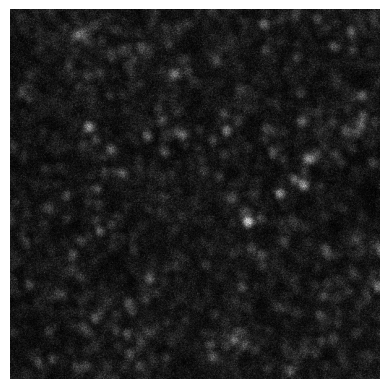

In [3]:
plt.imshow(img0, cmap='gray')
plt.axis('off')
plt.show()

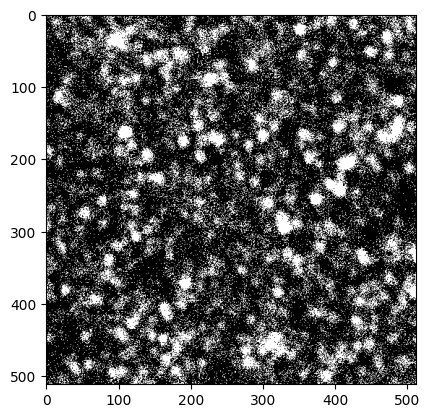

In [23]:
# adjust the image with cv2
img0_array = np.array(img0)

# threshold the image
_, img0_thresh = cv.threshold(img0_array, 60, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# make value from 0 to 1
img0_thresh = img0_thresh / 255

#plot
plt.imshow(img0_thresh, cmap='gray')

In [28]:
#print max and min value
print(np.max(img0_array))
print(np.min(img0_array))
print(img0_array)

1954
26
[[436 118 332 ... 271 439 133]
 [246 233  96 ... 254 338 179]
 [318 369 223 ... 388 427 251]
 ...
 [446 358 179 ... 158 160 452]
 [241 237 245 ... 178 355 357]
 [287 249 260 ... 231 275 236]]


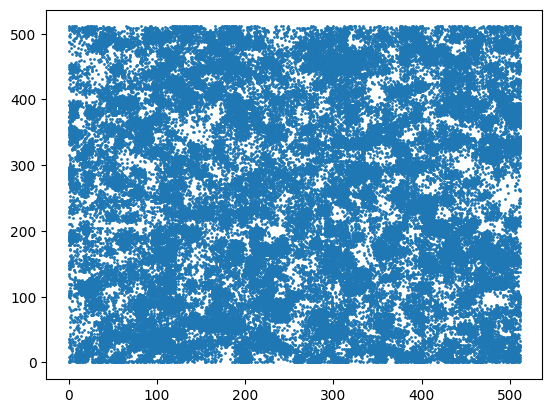

In [14]:
# Convert the image to points
points = np.argwhere(img0_thresh == 1)

#plot the points
plt.scatter(points[:, 1], points[:, 0], s=1)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


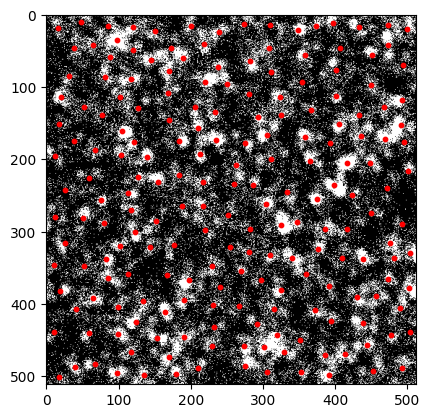

In [18]:
# K-means clustering
kmeans = KMeans(n_clusters=200, random_state=0).fit(points)
cluster_centers = kmeans.cluster_centers_

#plot the cluster centers
plt.scatter(cluster_centers[:, 1], cluster_centers[:, 0], s=10, c='red')
plt.imshow(img0_thresh, cmap='gray')
plt.show()

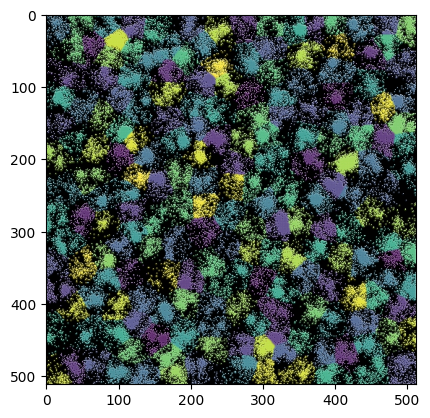

In [19]:
#plot clusters with different colors
plt.scatter(points[:, 1], points[:, 0], s=1, c=kmeans.labels_, alpha=0.1)
plt.imshow(img0_thresh, cmap='gray')
plt.show()

0.14278403275332652 0.8208802456499488
[0.17211011638731552, 0, 0.18993284947737352, 0.18807423685953398, 0.18787944644634821, 0.17419226275124322, 0.18416571805737572, 0.20204967415104363, 0, 0.18600328809067476, 0, 0.20209152304386574, 0.17845990782931276, 0.18944646466724616, 0.2108407157731267, 0, 0.20224150162737675, 0.1900581506518047, 0, 0, 0.19800224994697868, 0.21384180652617868, 0.1961309616120261, 0.18656354211377818, 0.18025852894724356, 0.19082329880692214, 0.18774201455482573, 0.18721687931331518, 0.19976596552160367, 0, 0.1947085416904889, 0.2041690590907956, 0.20008252767651136, 0, 0, 0.1769534417039947, 0.21706703387852894, 0, 0, 0.22002077833079275, 0.1820297331907413, 0.17881725019579892, 0.18549431031368535, 0.17744866626282038, 0.1933342721521161, 0.1991698273109507, 0.19107545843558468, 0.18803918701564556, 0.19007194718286674, 0.19026805720766826, 0.18784613682259538, 0.17020663067818714, 0.21938802995205517, 0, 0, 0.19880400333062362, 0.20980015094651738, 0.1812

c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


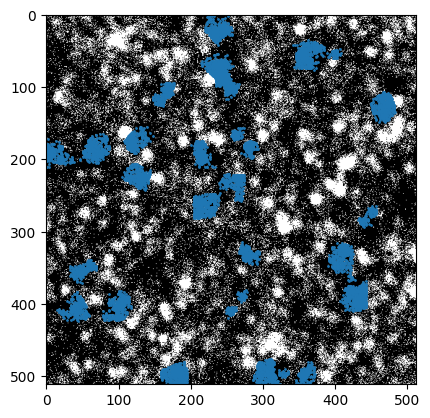

In [34]:
cluster_labels = kmeans.labels_
unique_labels, counts = np.unique(cluster_labels, return_counts=True)

# Settings for removal
N_small = 10  # Number of smallest clusters to remove
N_big = 25    # Number of biggest clusters to remove
N_sparse = 30 # Number of most sparse clusters to remove after the first removal
brightness_threshold = 0  # Threshold for brightness

# Identify the smallest and biggest clusters
sorted_indices = np.argsort(counts)
smallest_clusters_indices = sorted_indices[:N_small]
biggest_clusters_indices = sorted_indices[-N_big:]

# Remove the N smallest and N biggest clusters
intermediate_points_to_keep = np.logical_and(~np.isin(cluster_labels, smallest_clusters_indices),
                                             ~np.isin(cluster_labels, biggest_clusters_indices))
filtered_points = points[intermediate_points_to_keep]
filtered_labels = cluster_labels[intermediate_points_to_keep]

# Remove the points with brightness above the threshold
brightness = img0_array[filtered_points[:, 0], filtered_points[:, 1]]
brightness_normalized = brightness / np.max(img0_array)
print(min(brightness_normalized), max(brightness_normalized))
#for each cluster, calculate the average brightness of the pixels in the cluster
average_brightness = []
for i in range(200 - N_small - N_big):
    cluster_points = filtered_points[filtered_labels == i]
    cluster_brightness = brightness_normalized[filtered_labels == i]
    mean_brightness = np.mean(cluster_brightness)
    if np.isnan(mean_brightness):
        mean_brightness = 0
    average_brightness.append(mean_brightness)

print(average_brightness)
#get the indices of the clusters with brightness above the threshold
bright_clusters_indices = np.where(np.array(average_brightness) > brightness_threshold)[0]
#filter out the clusters with brightness above the threshold
final_points_to_keep = ~np.isin(filtered_labels, bright_clusters_indices)
filtered_points = filtered_points[final_points_to_keep]


# Re-clustering the filtered points
kmeans_filtered = KMeans(n_clusters=len(unique_labels) - N_small - N_big).fit(filtered_points)
filtered_cluster_labels = kmeans_filtered.labels_
filtered_centroids = kmeans_filtered.cluster_centers_

# Calculate sparsity for the new clusters
average_distances = []
for i, centroid in enumerate(filtered_centroids):
    cluster_points = filtered_points[filtered_cluster_labels == i]
    distances = pairwise_distances(cluster_points, [centroid])
    average_distance = np.mean(distances)
    average_distances.append(average_distance)

# Determine the N most sparse clusters
sparse_clusters_indices = np.argsort(average_distances)[-N_sparse:]

# Filter out the N most sparse clusters
final_points_to_keep = ~np.isin(filtered_cluster_labels, sparse_clusters_indices)
final_filtered_points = filtered_points[final_points_to_keep]

# Plot the final filtered points
plt.scatter(final_filtered_points[:, 1], final_filtered_points[:, 0], s=1)
plt.imshow(img0_thresh, cmap='gray')  # Ensure img0_thresh is defined
plt.show()

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


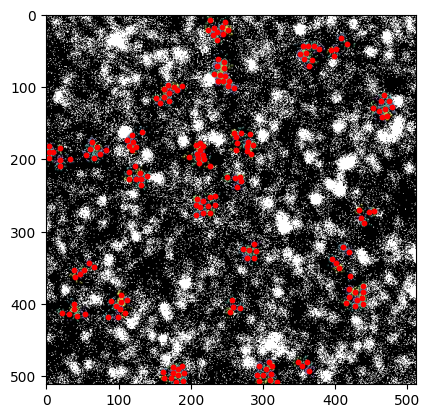

In [10]:
# Re-run K-means clustering
kmeans_final = KMeans(n_clusters=200).fit(final_filtered_points)
final_cluster_centers = kmeans_final.cluster_centers_
final_cluster_labels = kmeans_final.labels_

# Plot the final cluster centers
plt.scatter(final_filtered_points[:, 1], final_filtered_points[:, 0], s=1, c=kmeans_final.labels_, alpha=0.1)
plt.scatter(final_cluster_centers[:, 1], final_cluster_centers[:, 0], s=10, c='red')
plt.imshow(img0_thresh, cmap='gray')  # Ensure img0_thresh is defined
plt.show()

200


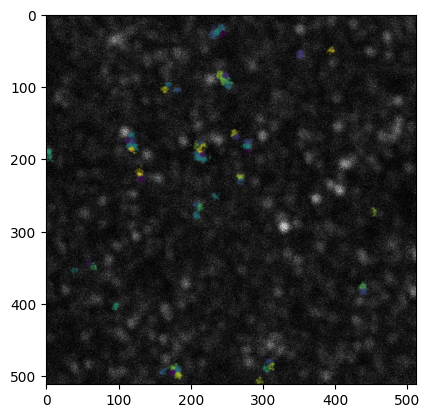

In [11]:
# Calculate sparsity (or density) for these clusters
final_average_distances = []
for i, centroid in enumerate(final_cluster_centers):
    cluster_points = final_filtered_points[final_cluster_labels == i]
    distances = pairwise_distances(cluster_points, [centroid])
    average_distance = np.mean(distances)
    final_average_distances.append(average_distance)

print(len(final_average_distances))
# Determine the M least sparse (most dense) clusters
M = 5  # Number of most dense clusters to keep; adjust as needed
dense_clusters_indices = np.argsort(final_average_distances)[0:60]

# Keep only the points from the M most dense clusters
most_dense_points_to_keep = np.isin(final_cluster_labels, dense_clusters_indices)
most_dense_points = final_filtered_points[most_dense_points_to_keep]

# Plot the most dense points
plt.scatter(most_dense_points[:, 1], most_dense_points[:, 0], s=1, c=final_cluster_labels[most_dense_points_to_keep], alpha=0.1)
plt.imshow(img0, cmap='gray')  # Ensure img0_thresh is defined
plt.show()

In [9]:
from cluster import get_clusters

centroids, labels, p = get_clusters(img0, 300, brightness_threshold=0,


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [10]:
#adjust img0 brightness with cv2
img0_array = np.array(img0)
img0_array = cv.convertScaleAbs(img0_array, alpha=0.4, beta=0)

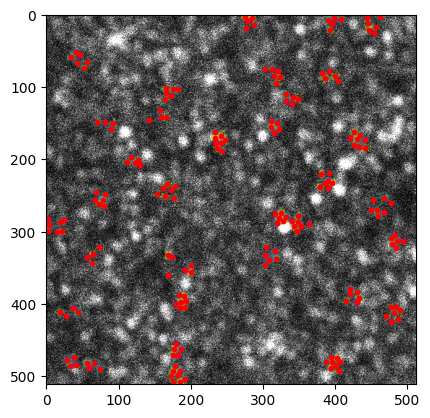

In [11]:
plt.scatter(p[:, 1], p[:, 0], s=1, c=labels, alpha=0.1)  
plt.scatter(centroids[:, 1], centroids[:, 0], s=10, c='red')
plt.imshow(img0_array, cmap='gray')
plt.show()